In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import requests
import json

from matplotlib import font_manager

# import nodes-values-relation tags

In [2]:
JSON_folder = "json_data/ncn_japan/"

with open(JSON_folder + 'nodes.json') as f:
    data = json.load(f)

# Normalize the JSON structure
df_nodes = pd.json_normalize(data)

with open(JSON_folder + 'ways.json') as f:
    data = json.load(f)
df_ways = pd.json_normalize(data)

with open(JSON_folder + 'relations.json') as f:
    data = json.load(f)
df_relation = pd.json_normalize(data)

# Extract the id, lat, lon, and expand the tags dictionary
#df_expanded = pd.json_normalize(data, 'tags', ['id', 'lat', 'lon'], sep='_')

In [3]:
df_nodes.columns = df_nodes.columns.str.replace('tags.', '', regex=False)
df_nodes = df_nodes.drop(columns=[col for col in df_nodes.columns if 'name' in col])

df_ways.columns = df_ways.columns.str.replace('tags.', '', regex=False)
df_ways = df_ways.drop(columns=[col for col in df_ways.columns if 'name' in col])

df_relation.columns = df_relation.columns.str.replace('tags.', '', regex=False)
df_relation = df_relation.drop(columns=[col for col in df_relation.columns if 'name' in col])

# Tags NAN frequency

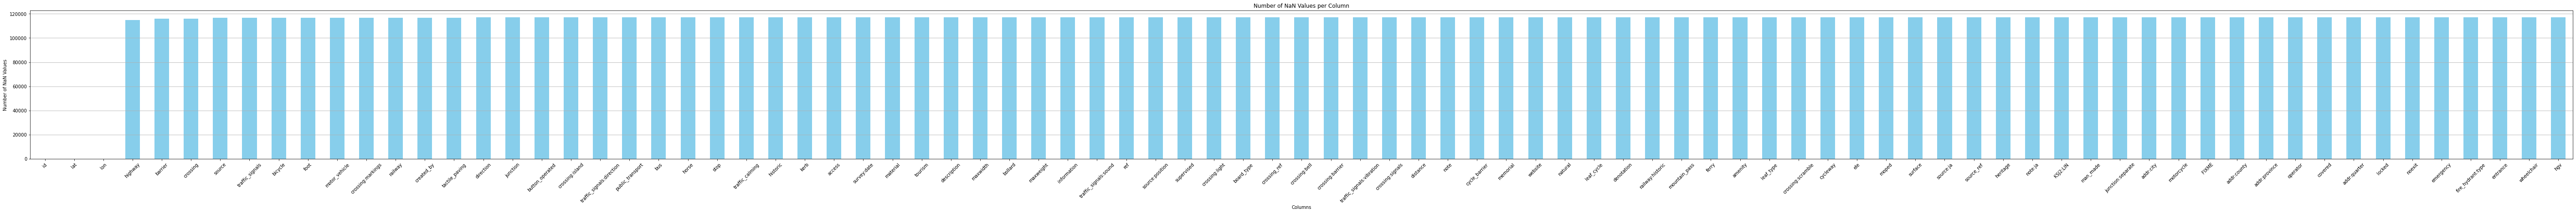

In [4]:
nan_count_nodes = df_nodes.isna().sum().sort_values()

plt.figure(figsize=(100, 6))
nan_count_nodes[0:100].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

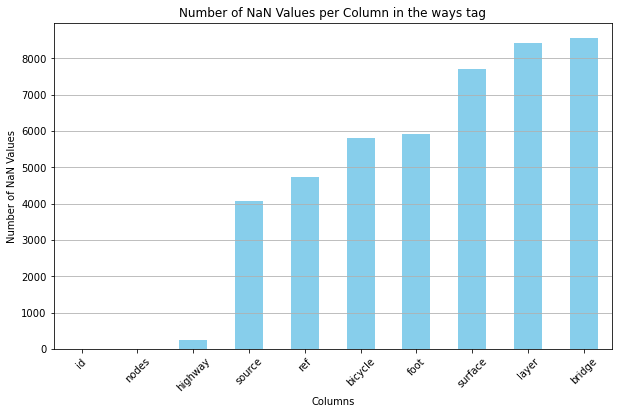

In [5]:
nan_count_ways = df_ways.isna().sum().sort_values()

plt.figure(figsize=(10, 6))
nan_count_ways[0:10].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column in the ways tag')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

#plt.savefig('Image/Nan_values_ways.png')

# Tags NAN frequency, for a specific tag=value

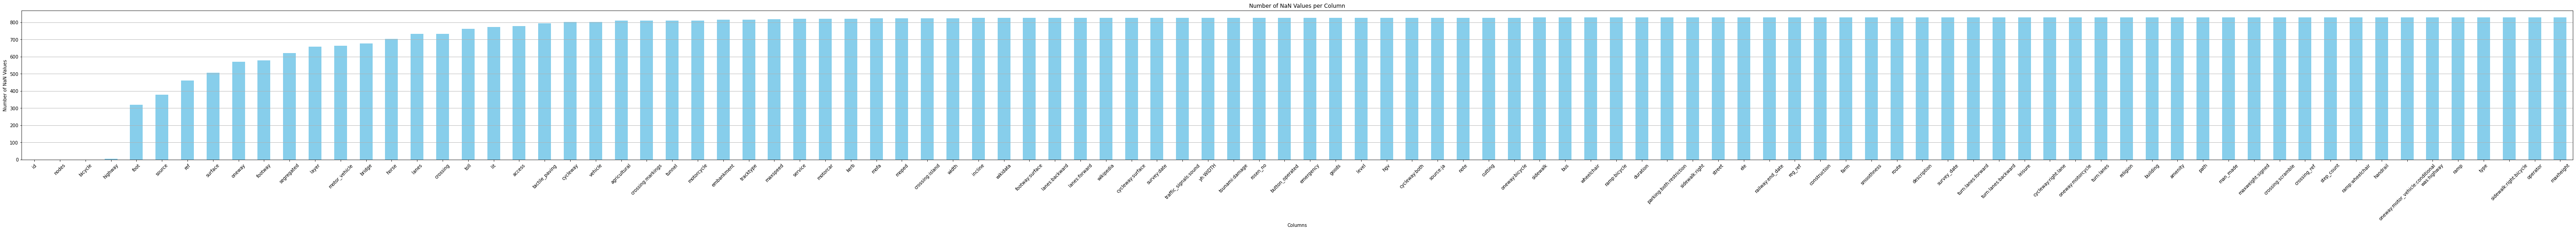

In [6]:
bicycle_tags = df_ways[df_ways["bicycle"] == "yes"]
bicycle_count = bicycle_tags.isna().sum().sort_values()

plt.figure(figsize=(100, 6))
bicycle_count[0:100].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Tags Frequency in NCN compare to frequency in all japan

## Ways

### Select important tags

In [7]:
tags_list = df_ways.columns[2:]

tag_ways = {}
for tag in tags_list:
    values = df_ways[tag].dropna().unique().tolist()
    if len(values) < 20 :
        tag_ways[tag] = values

### Extract global osm statistics for each of our tags

In [8]:
# Taginfo API endpoint
base_url = 'https://taginfo.openstreetmap.org/api/4/tag/stats'

# Function to fetch statistics for a key-value pair
def fetch_taginfo_stats(key, value):
    url = f"{base_url}?key={key}&value={value}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for key={key}, value={value}. Status code: {response.status_code}")
        return None



stat_nodes = {}
stat_ways = {}
stat_relations = {}

bool_load = False

# Iterate over keys and their values
if bool_load==True:
    i=0
    n_key=len(tag_ways.keys())
    for key, values in tag_ways.items():
        print(f"{i/n_key*100}%")
        i+=1
        dic_node = {}
        dic_ways = {}
        dic_relations = {}
        for value in values:
            print
            stats = fetch_taginfo_stats(key, value) 
            if stats:
                dic_node[value] = stats['data'][1]['count_fraction']
                dic_ways[value] = stats['data'][2]['count_fraction']
                dic_relations[value] = stats['data'][3]['count_fraction']
        stat_nodes[key] = dic_node
        stat_ways[key] = dic_ways
        stat_relations[key] = dic_relations

        with open(JSON_folder + 'stat_nodes.json', 'w') as json_file:
            json.dump(stat_nodes, json_file)
        with open(JSON_folder + 'stat_ways.json', 'w') as json_file:
            json.dump(stat_ways, json_file)
        with open(JSON_folder + 'stat_relations.json', 'w') as json_file:
            json.dump(stat_relations, json_file)
else :
    with open(JSON_folder + 'stat_nodes.json', 'r') as json_file:
        stat_nodes = json.load(json_file)
    with open(JSON_folder + 'stat_ways.json', 'r') as json_file:
        stat_ways = json.load(json_file)
    with open(JSON_folder + 'stat_relations.json', 'r') as json_file:
        stat_relations = json.load(json_file)



### Compare frequency

In [11]:
#n_total_node = 240_455_144

stat_ways_ncn = {}
df_ways_cut = df_ways[tag_ways.keys()]

for col in df_ways_cut.columns:
    dic_ways = {}
    for value, count in df_ways_cut[col].dropna().value_counts().items():
        dic_ways[value] = count/df_ways.shape[0] #REMULTIPLIER PAR LE NOMBRE DE NODE DANS LE TABLEAU NCN
    stat_ways_ncn[col] = dic_ways

In [13]:
df_stat_ways = pd.DataFrame(index=["stat ncn", "stat global"])
for tag in stat_ways_ncn.keys():
    for value in stat_ways_ncn[tag].keys():
        stat_ncn = stat_ways_ncn[tag][value]
        stat_all = stat_ways[tag][value]
        df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]

/tmp/ipykernel_19736/1027287588.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]
/tmp/ipykernel_19736/1027287588.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]
/tmp/ipykernel_19736/1027287588.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

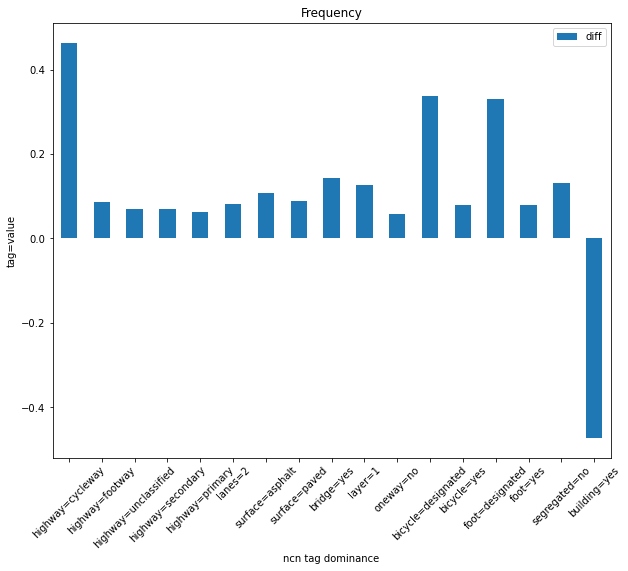

In [34]:
df_stat_ways.loc["diff"] = df_stat_ways.loc["stat ncn"] - df_stat_ways.loc["stat global"]
df_important_diff = df_stat_ways.T[(df_stat_ways.T["diff"] > 0.05) | (df_stat_ways.T["diff"] < -0.05)]


df_important_diff.plot(y="diff", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

plt.show()
#plt.savefig('Image/ncn_frequency.png')


## Nodes

### Select important tags

In [40]:
tags_list = df_nodes.columns[2:]

tag_nodes = {}
for tag in tags_list:
    values = df_nodes[tag].dropna().unique().tolist()
    if len(values) < 20 :
        tag_nodes[tag] = values

### Extract global osm statistics for each of our tags

In [43]:
# Taginfo API endpoint
base_url = 'https://taginfo.openstreetmap.org/api/4/tag/stats'

# Function to fetch statistics for a key-value pair
def fetch_taginfo_stats(key, value):
    url = f"{base_url}?key={key}&value={value}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for key={key}, value={value}. Status code: {response.status_code}")
        return None



stat_nodes_global = {}

bool_load = True

# Iterate over keys and their values
if bool_load==True:
    i=0
    n_key=len(tag_nodes.keys())
    for key, values in tag_nodes.items():
        print(f"{i/n_key*100}%")
        i+=1
        dic_node = {}
        for value in values:
            print
            stats = fetch_taginfo_stats(key, value) 
            if stats:
                dic_node[value] = stats['data'][1]['count_fraction']

        stat_nodes_global[key] = dic_node

        with open(JSON_folder + 'stat_nodes.json', 'w') as json_file:
            json.dump(stat_nodes, json_file)
else :
    with open(JSON_folder + 'stat_nodes.json', 'r') as json_file:
        stat_nodes_global = json.load(json_file)



0.0%
1.2048192771084338%
2.4096385542168677%
3.614457831325301%
4.819277108433735%
6.024096385542169%
7.228915662650602%
8.433734939759036%
9.63855421686747%
10.843373493975903%
12.048192771084338%
13.253012048192772%
14.457831325301203%
15.66265060240964%
16.867469879518072%
18.072289156626507%
19.27710843373494%
20.481927710843372%
21.686746987951807%
22.89156626506024%
24.096385542168676%
25.301204819277107%
26.506024096385545%
27.710843373493976%
28.915662650602407%
30.120481927710845%
31.32530120481928%
32.53012048192771%
33.734939759036145%
34.93975903614458%
36.144578313253014%
37.34939759036144%
38.55421686746988%
39.75903614457831%
40.963855421686745%
42.168674698795186%
43.373493975903614%
44.57831325301205%
45.78313253012048%
46.98795180722892%
48.19277108433735%
49.39759036144578%
50.602409638554214%
51.80722891566265%
53.01204819277109%
54.21686746987952%
55.42168674698795%
56.62650602409639%
57.831325301204814%
59.036144578313255%
60.24096385542169%
61.44578313253012%
62.

### Compare frequency

In [44]:
#n_total_node = 240_455_144

stat_nodes_ncn = {}
df_cut = df_nodes[tag_nodes.keys()]

for col in df_cut.columns:
    dic = {}
    for value, count in df_cut[col].dropna().value_counts().items():
        dic[value] = count/df_nodes.shape[0] # pourcentage du tag=value parmis les nodes extraient
    stat_nodes_ncn[col] = dic

In [45]:
df_stat_nodes = pd.DataFrame(index=["stat ncn", "stat global"])
for tag in stat_nodes_ncn.keys():
    for value in stat_nodes_ncn[tag].keys():
        stat_ncn = stat_nodes_ncn[tag][value]
        stat_all = stat_nodes_global[tag][value]
        df_stat_nodes[tag + "=" + value] = [stat_ncn, stat_all]

/tmp/ipykernel_19736/1480281698.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_nodes[tag + "=" + value] = [stat_ncn, stat_all]
/tmp/ipykernel_19736/1480281698.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_nodes[tag + "=" + value] = [stat_ncn, stat_all]
/tmp/ipykernel_19736/1480281698.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

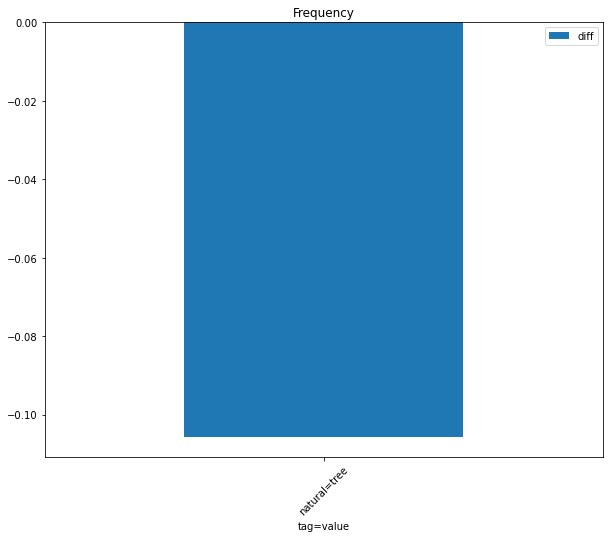

In [46]:
df_stat_nodes.loc["diff"] = df_stat_nodes.loc["stat ncn"] - df_stat_nodes.loc["stat global"]

df_important_diff = df_stat_nodes.T[(df_stat_nodes.T["diff"] > 0.05) | (df_stat_nodes.T["diff"] < -0.05)]
df_important_diff.plot(y="diff", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

plt.show()
#plt.savefig('Image/ncn_frequency.png')


## Relations

### Select important tags

In [54]:
tags_list = df_relation.columns[3:]

tag_relations = {}
for tag in tags_list:
    values = df_relation[tag].dropna().unique().tolist()
    if len(values) < 20 :
        tag_relations[tag] = values

TypeError: unhashable type: 'list'

### Extract global osm statistics for each of our tags

In [ ]:
# Taginfo API endpoint
base_url = 'https://taginfo.openstreetmap.org/api/4/tag/stats'

# Function to fetch statistics for a key-value pair
def fetch_taginfo_stats(key, value):
    url = f"{base_url}?key={key}&value={value}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for key={key}, value={value}. Status code: {response.status_code}")
        return None



stat_relations_global = {}

bool_load = False

# Iterate over keys and their values
if bool_load==True:
    i=0
    n_key=len(tag_relations.keys())
    for key, values in tag_relations.items():
        print(f"{i/n_key*100}%")
        i+=1
        dic = {}
        for value in values:
            print
            stats = fetch_taginfo_stats(key, value) 
            if stats:
                dic[value] = stats['data'][1]['count_fraction']

        stat_relations_global[key] = dic

        with open(JSON_folder + 'stat_relations.json', 'w') as json_file:
            json.dump(stat_nodes, json_file)
else :
    with open(JSON_folder + 'stat_relations.json', 'r') as json_file:
        stat_relations_global = json.load(json_file)



0.0%
0.7575757575757576%
1.5151515151515151%
2.272727272727273%
3.0303030303030303%


### Compare frequency

In [ ]:
#n_total_node = 240_455_144

stat_relations_ncn = {}
df_cut = df_relations[tag_relations.keys()]

for col in df_cut.columns:
    dic = {}
    for value, count in df_cut[col].dropna().value_counts().items():
        dic[value] = count/df_nodes.shape[0] # pourcentage du tag=value parmis les nodes extraient
    stat_relations_ncn[col] = dic

In [ ]:
df_stat_relations = pd.DataFrame(index=["stat ncn", "stat global"])
for tag in stat_relations_ncn.keys():
    for value in stat_relations_ncn[tag].keys():
        stat_ncn = stat_relations_ncn[tag][value]
        stat_all = stat_relations_global[tag][value]
        df_stat_relations[tag + "=" + value] = [stat_ncn, stat_all]

In [ ]:
df_stat_nodes.loc["diff"] = df_stat_nodes.loc["stat ncn"] - df_stat_nodes.loc["stat global"]

df_important_diff = df_stat_nodes.T[(df_stat_nodes.T["diff"] > 0.05) | (df_stat_nodes.T["diff"] < -0.05)]
df_important_diff.plot(y="diff", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

plt.show()
#plt.savefig('Image/ncn_frequency.png')
